In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
from keras.optimizers import Adam
import math
import pickle
import pandas
from sklearn.metrics import mean_squared_error

# LSTM Model


Epoch 1/100
1/1 [==============================] - 7s 7s/step - loss: 0.6220 - val_loss: 0.5751
Epoch 2/100
1/1 [==============================] - 0s 68ms/step - loss: 0.5771 - val_loss: 0.3216
Epoch 3/100
1/1 [==============================] - 0s 65ms/step - loss: 0.3223 - val_loss: 0.2660
Epoch 4/100
1/1 [==============================] - 0s 65ms/step - loss: 0.2661 - val_loss: 0.1155
Epoch 5/100
1/1 [==============================] - 0s 65ms/step - loss: 0.1156 - val_loss: 0.0578
Epoch 6/100
1/1 [==============================] - 0s 74ms/step - loss: 0.0581 - val_loss: 0.0342
Epoch 7/100
1/1 [==============================] - 0s 65ms/step - loss: 0.0344 - val_loss: 0.0205
Epoch 8/100
1/1 [==============================] - 0s 61ms/step - loss: 0.0205 - val_loss: 0.0216
Epoch 9/100
1/1 [==============================] - 0s 61ms/step - loss: 0.0214 - val_loss: 0.0274
Epoch 10/100
1/1 [==============================] - 0s 63ms/step - loss: 0.0272 - val_loss: 0.0286
Epoch 11/100
1/1 [==

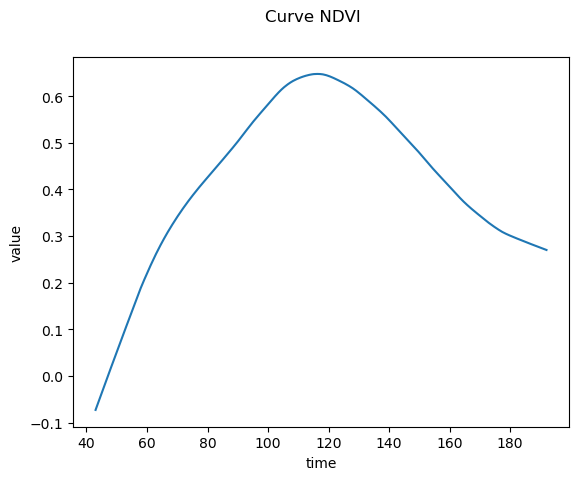

In [3]:
# Now to get the test set ready in a similar way as the training set.
# The following has been done so forst 60 entires of test set have 60 previous values which is impossible to get unless we take the whole 
# 'High' attribute data for processing
# generate the input and output sequences
with open('./pickles/NDVI.pickle', 'rb') as handle:
    NDVI = pickle.load(handle)
print()
NDVI[30].plot()

# Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))

datasetTrain = np.reshape(NDVI.mean().data_matrix.flatten(),(NDVI.mean().data_matrix.flatten().shape[0],1))
datasetTrain = sc.fit_transform(datasetTrain)
datasetTrain = datasetTrain.reshape(-1, 1)

datasetTest = np.reshape(NDVI[30].data_matrix.flatten(),(NDVI[30].data_matrix.flatten().shape[0],1))
datasetTest = sc.fit_transform(datasetTest)
datasetTest = datasetTest.reshape(-1, 1)

n_lookback = 30  # length of input sequences (lookback period)
n_forecast = 150-n_lookback  # length of output sequences (forecast period)
Nepoch = 100 # Numero di epoche

X = []
Y = []
for i in range(n_lookback, len(datasetTrain) - n_forecast + 1):
    X.append(datasetTrain[i - n_lookback: i])
    Y.append(datasetTrain[i: i + n_forecast])
X = np.array(X)
Y = np.array(Y)

X_val = []
Y_val = []
for i in range(n_lookback, len(datasetTrain) - n_forecast + 1):
    X_val.append(datasetTest[i - n_lookback: i])
    Y_val.append(datasetTest[i: i + n_forecast])
X_val = np.array(X_val)
Y_val = np.array(Y_val)

# The LSTM architecture
regressor = Sequential()
regressor.add(LSTM(units=60, return_sequences=True, input_shape=(n_lookback,1)))
regressor.add(LSTM(units=120, return_sequences=True))
regressor.add(LSTM(units=240, return_sequences=True))
regressor.add(LSTM(units=120))
# The output layer
regressor.add(Dense(n_forecast))

regressor.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.003, beta_1=0.9, beta_2=0.999, epsilon=1e-8))
history = regressor.fit(X, Y, epochs=Nepoch,validation_data=(X_val,Y_val), batch_size=32,use_multiprocessing=True)


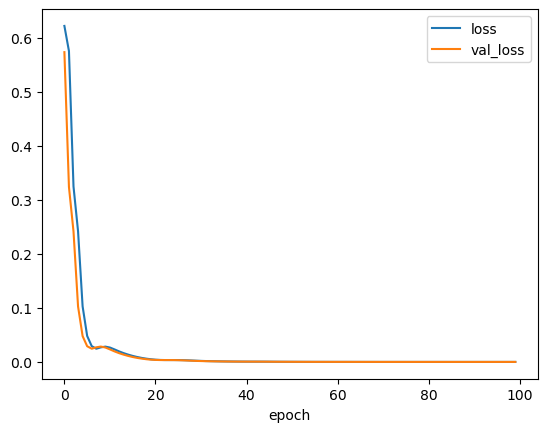

In [4]:
history_df = pd.DataFrame(columns=['epoch', 'loss'])
history_df['epoch'] = range(Nepoch)
history_df['loss'] = history.history['loss']
history_df['val_loss'] = history.history['val_loss']
history_df = history_df.set_index('epoch')
history_df.plot()

In [5]:


dataset_total = np.reshape(NDVI[90].data_matrix.flatten(),(NDVI[90].data_matrix.flatten().shape[0],1))
starttime = 0
stoptime = starttime+n_lookback
inputs = dataset_total[starttime:stoptime] # generare "l'ultima sequenza disponibile"
print(inputs[-3:])
inputs  = sc.transform(inputs)
inputs = inputs.reshape(1, n_lookback, 1)

predicted_stock_price = regressor.predict(inputs)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
print(predicted_stock_price[0][:3])

[[0.34833098]
 [0.35785852]
 [0.36707118]]
1/1 [==============================] - 1s 1s/step
[0.37186947 0.38083896 0.39095965]


C:\Users\Leo\AppData\Local\Temp\ipykernel_15408\4239727298.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = df_past.append(df_future).set_index('Date')


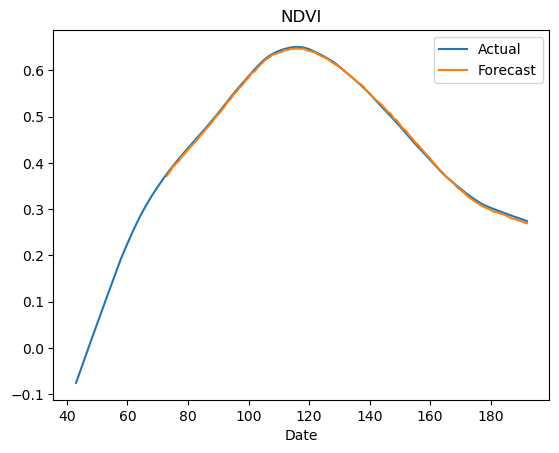

In [6]:
# organize the results in a data frame
Days = range(43,193)
df_past = pd.DataFrame(columns=['Date', 'Actual'])
df_past['Date'] = Days
df_past['Actual'] = dataset_total

df_future = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_future['Date'] = Days[stoptime:stoptime+n_forecast]
df_future['Forecast'] = predicted_stock_price.flatten()

results = df_past.append(df_future).set_index('Date')
results.plot(title='NDVI')

# Calculate the metrics

In [7]:
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse

predizione = df_future['Forecast']
present = df_past['Actual'][stoptime:stoptime+n_forecast]


# calculate MAE
error1 = np.round(mae(present, predizione),6)


# display
print("Mean absolute error : " + str(error1))

# calculate MSE
error2 = round(mse(present, predizione),6)
  
# display
print("Mean Square error : " + str(error2))
# calculate RMSE
print("R - Mean Square error : " + str(np.round(np.sqrt(error2),6)))

Mean absolute error : 0.002961
Mean Square error : 1.1e-05
R - Mean Square error : 0.003317


# GRU architecture

Epoch 1/100
1/1 [==============================] - 8s 8s/step - loss: 0.6221 - val_loss: 0.5351
Epoch 2/100
1/1 [==============================] - 0s 60ms/step - loss: 0.5368 - val_loss: 0.2077
Epoch 3/100
1/1 [==============================] - 0s 56ms/step - loss: 0.2079 - val_loss: 0.5280
Epoch 4/100
1/1 [==============================] - 0s 59ms/step - loss: 0.5272 - val_loss: 0.1522
Epoch 5/100
1/1 [==============================] - 0s 60ms/step - loss: 0.1522 - val_loss: 0.0982
Epoch 6/100
1/1 [==============================] - 0s 62ms/step - loss: 0.0988 - val_loss: 0.0971
Epoch 7/100
1/1 [==============================] - 0s 79ms/step - loss: 0.0975 - val_loss: 0.0632
Epoch 8/100
1/1 [==============================] - 0s 65ms/step - loss: 0.0635 - val_loss: 0.0624
Epoch 9/100
1/1 [==============================] - 0s 61ms/step - loss: 0.0626 - val_loss: 0.0602
Epoch 10/100
1/1 [==============================] - 0s 62ms/step - loss: 0.0603 - val_loss: 0.0432
Epoch 11/100
1/1 [===

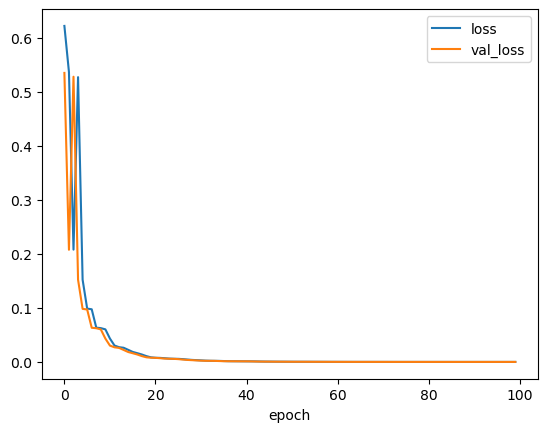

In [8]:
# The GRU architecture
Nepoch = 100
# The LSTM architecture
# The GRU architecture
regressorGRU = Sequential()
# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=60, return_sequences=True, input_shape=(n_lookback,1),activation='tanh'))
regressorGRU.add(GRU(units=120, return_sequences=True, input_shape=(n_lookback,1),activation='tanh'))
regressorGRU.add(GRU(units=240, return_sequences=True, input_shape=(n_lookback,1),activation='tanh'))
regressorGRU.add(GRU(units=120,activation='tanh'))
regressorGRU.add(Dense(units=n_forecast))
# Compiling the RNN
#regressorGRU.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
regressorGRU.compile(optimizer=Adam(learning_rate=0.004, beta_1=0.9, beta_2=0.999, epsilon=1e-8),loss='mean_squared_error')
# Fitting to the training set
gruHistory = regressorGRU.fit(X,Y,epochs=Nepoch,validation_data=(X_val,Y_val),batch_size=32)

history_df = pd.DataFrame(columns=['epoch', 'loss'])
history_df['epoch'] = range(Nepoch)
history_df['loss'] = gruHistory.history['loss']
history_df['val_loss'] = gruHistory.history['val_loss']
history_df = history_df.set_index('epoch')
history_df.plot()

[[0.34833098]
 [0.35785852]
 [0.36707118]]
1/1 [==============================] - 1s 1s/step
[0.37159404 0.38089862 0.38810998]


C:\Users\Leo\AppData\Local\Temp\ipykernel_15408\4145982864.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = df_past.append(df_future).set_index('Date')


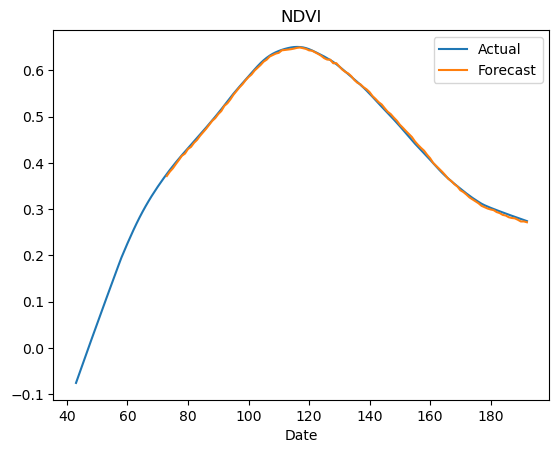

In [9]:
dataset_total = np.reshape(NDVI[90].data_matrix.flatten(),(NDVI[90].data_matrix.flatten().shape[0],1))
starttime = 0
stoptime = starttime+n_lookback
inputs = dataset_total[starttime:stoptime] # generate last available sequence"
print(inputs[-3:])
inputs  = sc.transform(inputs)
inputs = inputs.reshape(1, n_lookback, 1)

predicted_stock_price = regressorGRU.predict(inputs)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
print(predicted_stock_price[0][:3])

# organize the results in a data frame
Days = range(43,193)
df_past = pd.DataFrame(columns=['Date', 'Actual'])
df_past['Date'] = Days
df_past['Actual'] = dataset_total

df_future = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_future['Date'] = Days[stoptime:stoptime+n_forecast]
df_future['Forecast'] = predicted_stock_price.flatten()

results = df_past.append(df_future).set_index('Date')
results.plot(title='NDVI')

# calculate the metrics

In [197]:
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse

predizione = df_future['Forecast']
present = df_past['Actual'][stoptime:stoptime+n_forecast]


# calculate MAE
error1 = np.round(mae(present, predizione),6)
print("Mean absolute error : " + str(error1))

# calculate MSE
error2 = round(mse(present, predizione),6)
print("Mean Square error : " + str(error2))
# calculate RMSE
print("R - Mean Square error : " + str(np.round(np.sqrt(error2),6)))

Mean absolute error : 0.00268
Mean Square error : 9e-06
R - Mean Square error : 0.003
